In [1]:
#Problemdefinition

#Input: Egenskaper för låtar, såsom genre, tempo, energi, ljudegenskaper m.m.

#Output: Binär klassificering — populär eller inte populär.

#Syfte: Att bygga en maskininlärningsmodell som kan förutsäga låtars popularitet med hög precision och balanserad klassprestanda.

#Motivering för valet av problem
#Att förutsäga låtars popularitet är ett relevant problem i dagens musikindustri, 
#där algoritmer i stor utsträckning styr vad som når lyssnare. Ett prediktivt verktyg kan bidra till förbättrade rekommendationssystem,
#musikanalys och strategisk marknadsföring. Datasetet innehåller mångsidiga och kvantitativa egenskaper om låtar, 
#vilket gör det väl lämpat för maskininlärning och klassificeringsuppgifter. 
#Genom att analysera denna data kan vi dra insiktsfulla slutsatser om vilka faktorer som påverkar populäritet och samtidigt 
#demonstrera värdet av datadrivna beslut i musikbranschen.

# Core
#1.Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay
)

# Imbalance handling
from imblearn.over_sampling import RandomOverSampler

RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

#Explanation:
#pandas and numpy → to process and transform the dataset.
#matplotlib → to visualize distributions and results.
#train_test_split → divides the dataset into training (to build the model)
#and test (to evaluate it).
#LogisticRegression → a simple baseline classification model.
#accuracy_score, classification_report, f1_score, ConfusionMatrixDisplay
# to measure how well the model works.•
#RandomOverSampler → ensures both classes (popular / not popular)
#have the same size by duplicating minority samples.

#Varför behöver vi detta? Tänk dig en verktygslåda för att hela modellen så vi kan visualisera och träna och utvärdera våran modell.


In [2]:
#2.Load the Dataset
#We load the CSV file containing Spotify data and check the first rows to ensure everything looks correct.
# Load your local CSV (keep the exact filename you have)
CSV_PATH = "Popular_Spotify_Songs (1).csv"
df = pd.read_csv(CSV_PATH, encoding="latin1")

# Quick sanity check
print(df.shape)
df.head()



#Explanation:

#	pd.read_csv(...) → loads the dataset into a DataFrame (df).
#	encoding='latin1' → avoids issues with special characters (e.g., Swedish or accented letters).
#	df.head() → prints the first five rows so we can verify the structure of the data.


#Detta gör vi för att säkerhetsställa att allt laddats in rätt, och få in en överblick över datasetets strukur.

(953, 24)


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6


In [3]:

#3. Create Target Column (Popularity Label)

#Here we classify songs into popular or not popular based on how many playlists they appear in. 
#We start with the threshold = 5000.

# Define a function to classify songs based on playlist count
def classify_popularity(playlist_count):                    # input = number of playlists
    if playlist_count >= 5000:                              # threshold = 5000 playlists
        return "populär"                                    # considered popular
    else:
        return "inte populär"                               # considered not popular

# Apply the function to create a new column
df["popularity_category"] = df["in_spotify_playlists"].apply(classify_popularity)

# Show counts of each category
print("Counts at threshold=5000:")
print(df["popularity_category"].value_counts())

#Explanation:

#	classify_popularity: function that checks if a song has ≥5000 playlists.
#	If yes → “populär”, otherwise “inte populär”.
#	We then create a new column, popularity_category, in the dataset.
#	Finally, we print the distribution of the two classes.

#Varför? Detta görs för att definera vårat mål (target), vi omvandlar ett numeriskt värde (in_spotify_playlist) 
#till en binär katogeri som är lämlplig att träna denna modell.



Counts at threshold=5000:
popularity_category
inte populär    692
populär         261
Name: count, dtype: int64


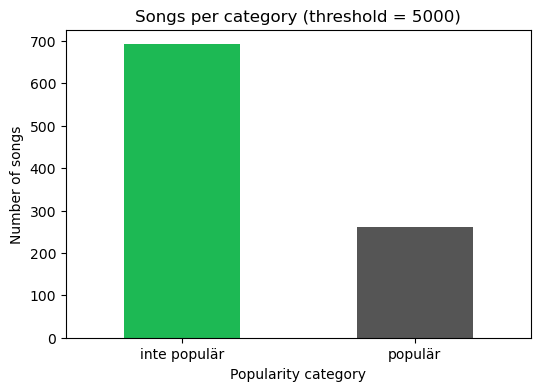


Class distribution (percent):
popularity_category
inte populär    72.612802
populär         27.387198
Name: count, dtype: float64


In [4]:

#4. Visualize Class Distribution (Before Balancing)

#This step shows how many songs fall into “populär” vs “inte populär” at the chosen threshold (5000). 

# Count how many songs are in each category
class_counts = df["popularity_category"].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar", color=["#1DB954", "#555555"])   # Spotify green & grey
plt.title("Songs per category (threshold = 5000)")
plt.xlabel("Popularity category")
plt.ylabel("Number of songs")
plt.xticks(rotation=0)
plt.show()

# Print percentages for clarity
print("\nClass distribution (percent):")
print(class_counts / len(df) * 100)



#Explanation:

#	value_counts() → counts how many songs are popular vs not popular.
#	A bar chart makes imbalance visible (e.g., 70% “inte populär”, 30% “populär”).
#	We also print the percentages, since the examiner asked for this reasoning.

#Varför?
#Vi gör detta för att förstå datasetens klassbalans, här upptäcker vi att modellen är obalanserad vilket kommer påverka resultatet.
# Visuellt



In [5]:

#5.Encode Categorical Features & Select Final Features

#Machine learning models only work with numbers, so we must convert text (categorical variables) 
#like mode and key into numeric values. Then we pick which features we’ll use to train the model.

# Encode 'mode' → Major = 1, Minor = 0
df["mode_encoded"] = df["mode"].map({"Major": 1, "Minor": 0})

# One-hot encode the musical key (creates dummy columns: key_A, key_B, etc.)
df = pd.get_dummies(df, columns=["key"], prefix="key")

# Define candidate feature set
feature_columns = [
    "bpm",
    "danceability_%",
    "valence_%",
    "energy_%",
    "acousticness_%",
    "instrumentalness_%",
    "liveness_%",
    "speechiness_%",
    "released_year",        
    "mode_encoded"
]

# X = input features, y = target labels
X = df[feature_columns]
y = df["popularity_category"]

print("Selected features:", feature_columns)#




#Explanation:

#	mode_encoded: We turn text into numbers (Major = 1, Minor = 0).
#	key: Converted with one-hot encoding → each key becomes its own
#   column (key_A, key_B, …).
#	Teacher’s feedback: We now include released_year since it had a relatively high absolute
#    correlation (≈ -0.39). Negative or positive doesn’t matter — strong correlation helps.
#	X and y:
#	X = input features (used for training).
#	y = target label (popular vs not popular).

#Varför
#Maskin inlärning kan bara jobba med numerisk data,(information som uttrycks i siffror) 
#vi har valt relevanta features som har hög korrelation med popularitet.


Selected features: ['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'released_year', 'mode_encoded']


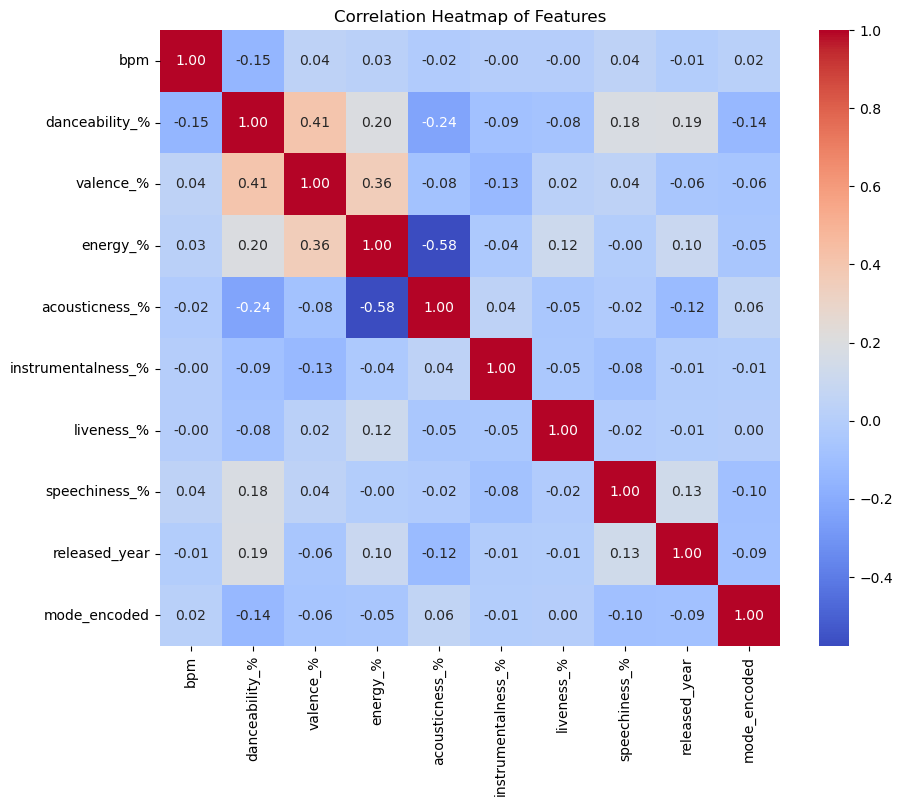

In [6]:
# Correlation heatmap for selected features
plt.figure(figsize=(10,8))
sns.heatmap(df[feature_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()
#Varför?
#För att förstå features och visa relationer innan vi går vidare till modellträning

🔹 Baseline accuracy: 0.8010471204188482

🔹 Classification report (Baseline):

              precision    recall  f1-score   support

inte populär       0.79      0.99      0.88       139
     populär       0.89      0.31      0.46        52

    accuracy                           0.80       191
   macro avg       0.84      0.65      0.67       191
weighted avg       0.82      0.80      0.76       191



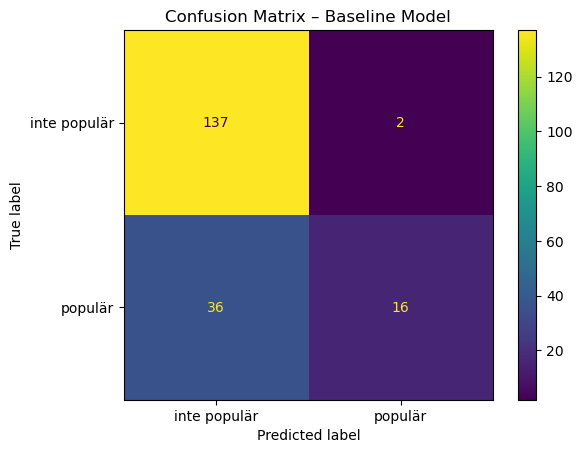

🔹 Baseline Macro-F1: 0.6676739926739926


In [7]:

#6. Baseline Model (Without Balancing

#We first train a simple Logistic Regression on the original (imbalanced) dataset. 
#This gives us a baseline to compare against later.


# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Train baseline Logistic Regression
baseline_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
baseline_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_base = baseline_model.predict(X_test)

# Evaluate baseline model
print("🔹 Baseline accuracy:", accuracy_score(y_test, y_pred_base))
print("\n🔹 Classification report (Baseline):\n")
print(classification_report(y_test, y_pred_base, zero_division=0))

# Confusion Matrix for visual clarity
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, labels=["inte populär", "populär"])
plt.title("Confusion Matrix – Baseline Model")
plt.show()

# Extra: Macro-F1 score
print("🔹 Baseline Macro-F1:", f1_score(y_test, y_pred_base, average="macro"))

#Explination
#	train_test_split: Splits data into train (80%) and test (20%). We use stratify=y to preserve the same class balance in both sets.
#	LogisticRegression: A simple linear classifier. max_iter=1000 avoids convergence warnings.
#	Evaluation:
#	Accuracy: How many predictions are correct.
#	Classification Report: Shows precision, recall, and F1-score per class.
#	Confusion Matrix: Visualizes correct vs incorrect predictions.
#	Macro-F1: Teacher recommended → averages performance equally across classes.
#	This is the starting point. Because the dataset is imbalanced, we expect the model to perform better at predicting 
# “inte populär” and worse at “populär”.

#Varför?
#För att se vad för obolans våran nuvarande modell har såhär
#ser våran modell ut utan någon balansering. Den har en extremt hög obalans.
#Modellen missar populära låtar 0,31 låtar hittar den bara, modellen lär sig och favoriserar den datan som är större.



🔹 Class counts after balancing:
popularity_category
inte populär    692
populär         692
Name: count, dtype: int64

🔹 Class share after balancing:
popularity_category
inte populär    0.5
populär         0.5
Name: proportion, dtype: float64


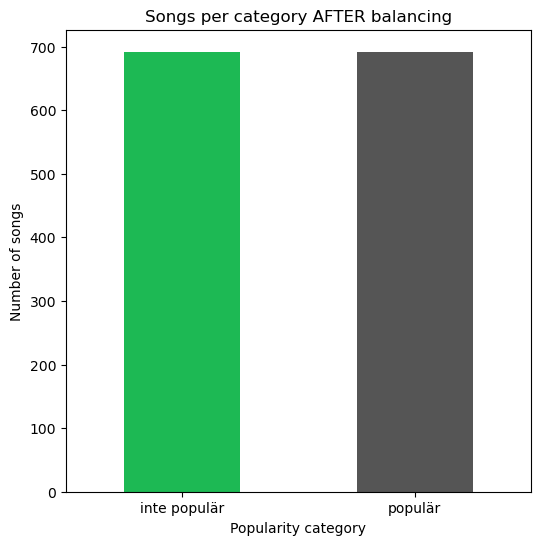

In [8]:

#7. Balance the Dataset (Oversampling)

#We saw earlier that the dataset is imbalanced (many more “inte populär” songs than “populär”). 
#To make the model learn more fairly, we apply oversampling → duplicate minority-class samples until both classes are equal.


# Initialize oversampler
oversampler = RandomOverSampler(random_state=RANDOM_STATE)

# Apply oversampling to features (X) and labels (y)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Check new class distribution
print("🔹 Class counts after balancing:")
print(y_resampled.value_counts())
print("\n🔹 Class share after balancing:")
print(y_resampled.value_counts(normalize=True).round(3))

# Visualize balanced distribution
plt.figure(figsize=(6,6))
y_resampled.value_counts().plot(kind="bar", color=["#1DB954", "#555555"])
plt.title("Songs per category AFTER balancing")
plt.xlabel("Popularity category")
plt.ylabel("Number of songs")
plt.xticks(rotation=0)
plt.show()

#Explanation:

#	RandomOverSampler: Copies rows from the minority class (“populär”)
#     until both classes are equally represented. fit_resample(X, y): Produces new balanced X_resampled, y_resampled.
#	Value counts: Now each class should have the same number of samples (≈50/50).
#	Plot: The bar chart clearly shows the new balanced dataset.

#Varför?
#Detta görs eftersom modellen hade en sådan stor obalans, 
#så nu ger vi modellen lika mycket att jämnföra med får lika många exempel från varje klass.
#Om modellen har mer data från något av specifika klasserna kommer resultatet luta åt det hållet.
#Även om själva "accuray" är lägre så ger det en mer rättvis modell
#Vi sänker "inte populär" klassen till samma antal som finns i "populär" klassen för att få en bättre jämnförelse.


C:\Users\brant\AppData\Local\Temp\ipykernel_69980\2676322103.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="viridis")


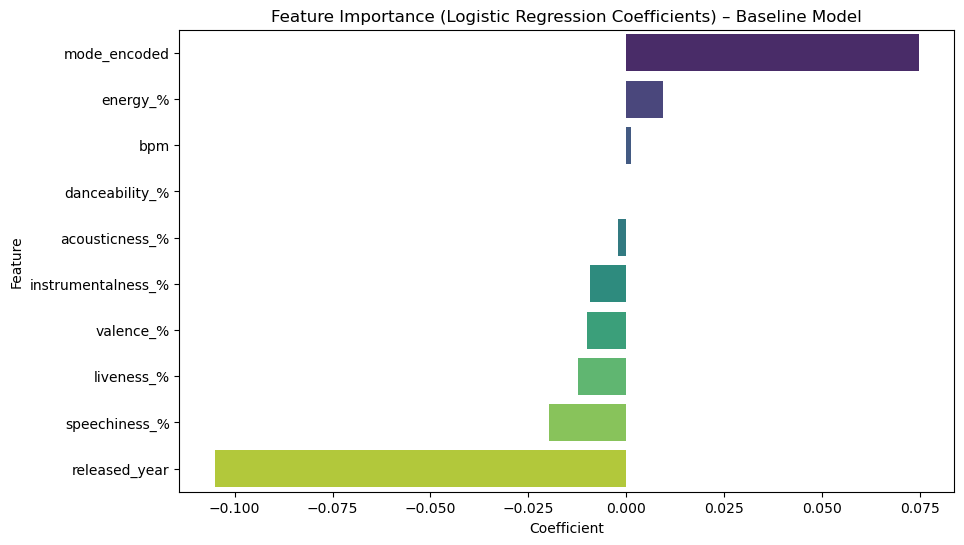

In [9]:
# Get coefficients and match with feature names
coef_df = pd.DataFrame({
    "Feature": feature_columns,
    "Coefficient": baseline_model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="viridis")
plt.title("Feature Importance (Logistic Regression Coefficients) – Baseline Model")
plt.show()
#Varför visas detta?
#För att visa vad som påverkar resultatet mest. Ju högre den är på den låten ju mer gör att den blir mer populär

🔹 Oversampled accuracy: 0.7725631768953068

🔹 Classification report (Oversampled):

              precision    recall  f1-score   support

inte populär       0.72      0.88      0.80       139
     populär       0.85      0.66      0.74       138

    accuracy                           0.77       277
   macro avg       0.79      0.77      0.77       277
weighted avg       0.79      0.77      0.77       277



C:\Users\brant\miniconda3\envs\mittprojekt\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


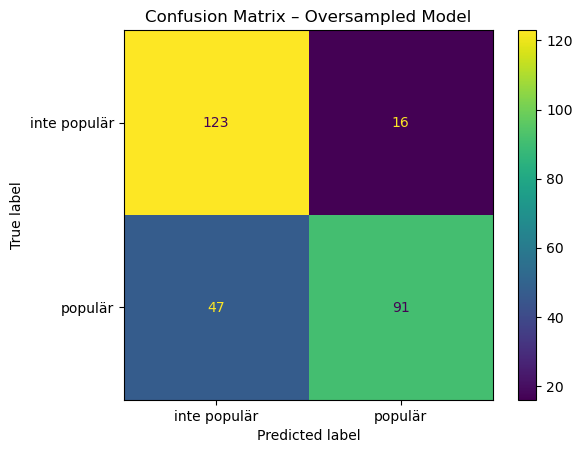

🔹 Oversampled Macro-F1: 0.769486823855756


In [10]:
# Split balanced data into train/test
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=RANDOM_STATE, stratify=y_resampled
)

# Train Logistic Regression on balanced data
model_os = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model_os.fit(X_train_os, y_train_os)

# Predict on test split
y_pred_os = model_os.predict(X_test_os)

# Evaluate balanced model
print("🔹 Oversampled accuracy:", accuracy_score(y_test_os, y_pred_os))
print("\n🔹 Classification report (Oversampled):\n")
print(classification_report(y_test_os, y_pred_os, zero_division=0))

# Confusion Matrix for oversampled model
ConfusionMatrixDisplay.from_predictions(y_test_os, y_pred_os, labels=["inte populär", "populär"])
plt.title("Confusion Matrix – Oversampled Model")
plt.show()

# Macro-F1 (teacher asked for this)
print("🔹 Oversampled Macro-F1:", f1_score(y_test_os, y_pred_os, average="macro"))

#Varför?

#Den här koden används för att träna, utvärdera och förstå hur en maskininlärningsmodell presterar på ett balanserat dataset. 
#Eftersom datasetet ursprungligen var obalanserat (fler exempel av "inte populär" än "populär"), 
#kan en modell annars bli partisk och bara lära sig känna igen majoritetsklassen.

#Genom att oversampla minoritetsklassen skapar vi ett dataset där båda klasserna har lika många exempel. 
#Därefter delas detta dataset i träning och test med train_test_split (med stratify=y_resampled för att säkerställa att båda klasserna,
#fördelas lika i båda delarna). Detta gör att modellen tränas och testas på data som är representativ för båda klasserna.

#När modellen tränas på den balanserade träningen och testas på en separat del av datan kan vi få en realistisk bild av hur väl modellen
#presterar i praktiken. Utvärderingen med accuracy, classification report, 
#confusion matrix och Macro-F1-score ger oss flera perspektiv:

#Accuracy visar andelen korrekt klassificerade exempel.

#Classification report visar precision och recall för varje klass.

#Confusion matrix visar hur många exempel som är felklassificerade och vilken typ av fel som uppstår.

#Macro-F1 ger ett balanserat mått på prestanda som inte låter majoritetsklassen dominera resultatet.

#Sammanfattningsvis: Denna kod är viktig för att säkerställa att modellen inte bara lär sig majoritetsklassen, 
#utan även presterar rättvist och robust för båda klasserna. Det ger en mer rättvis, transparent och pålitlig modell.

## Slutsats

Vi valde att formulera popularitetsproblemet som en binär klassificering (populär vs inte populär) baserat på antalet Spotify-spellistor (tröskel 5000).
En obalanserad baseline visade hög accuracy (~0.80) men dålig förmåga att upptäcka populära låtar (recall ≈ 0.31). 
Efter balansering med RandomOverSampler förbättrades macro-F1 från ≈0.67 till ≈0.77 och recall för den populära klassen ökade till ≈0.66,
vilket visar att modellen nu är mycket bättre på att hitta verkliga populära låtar. 

Detta resultat visar att hantering av klassobalans är avgörande när minoritetsklassen är affärskritisk. Modellen är dock begränsad av datasetets storlek,
målvariabelns definition och att många aspekter av vad som gör en låt populär 
(t.ex. marknadsföring, virala effekter) inte finns med i våra features. 
För att förbättra modellen rekommenderas följande: prova SMOTE eller andra syntetiska metoder, testa träd-baserade modeller 
(Random Forest, XGBoost), göra hyperparameter-sökning och använda stratifierad cross-validation samt tidsbaserad validering. 
Dessa steg förväntas ge robustare och mer generaliserbara resultat.
